<a href="https://colab.research.google.com/github/taaha3244/AI-Agents/blob/main/langraph.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -U langchain langchain_openai langsmith pandas langchain_experimental matplotlib langgraph langchain_core qdrant-client

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 975.5/975.5 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.9/45.9 kB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.5/127.5 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 19.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 202.7/202.7 kB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 28.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.0/89.0 kB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 337.4/337.4 kB 27.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 254.1/254.1 kB 19.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 328.3/328.3 kB 28.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 44.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.1/141.1 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━

In [2]:
from google.colab import userdata
import os
from qdrant_client import QdrantClient
from langchain.document_loaders import PDFPlumberLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.embeddings.openai import OpenAIEmbeddings
from langchain.vectorstores.qdrant import Qdrant
from langchain_openai import ChatOpenAI
from langchain.prompts import PromptTemplate
from langchain_core.runnables import RunnablePassthrough
from langchain_core.output_parsers import StrOutputParser
from typing import List,Optional,Type
from langchain import hub
from langchain_core.messages import (
    BaseMessage,
    HumanMessage,
    ToolMessage,
)
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langgraph.graph import END, StateGraph
from langchain.pydantic_v1 import BaseModel, Field
from langchain_core.tools import BaseTool
from langchain_openai import ChatOpenAI
import functools
from langchain_core.messages import AIMessage

In [3]:
openai_api_key=userdata.get('openai_api_key')

In [4]:
def create_agent(llm, tools=None, system_message: str = None):
    """Create an agent."""
    tool_names = ", ".join([tool.name for tool in tools]) if tools else "None"
    prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                "You are a helpful AI assistant, collaborating with other assistants."
                " Use the provided tools to progress towards answering the question."
                " If you are unable to fully answer, that's OK, another assistant with different tools "
                " will help where you left off. Execute what you can to make progress."
                " If you or any of the other assistants have the final answer or deliverable,"
                " prefix your response with FINAL ANSWER so the team knows to stop."
                " You have access to the following tools: {tool_names}.\n{system_message}",
            ),
            MessagesPlaceholder(variable_name="messages"),
        ]
    )
    prompt = prompt.partial(system_message=system_message, tool_names=tool_names)
    if tools:
        return prompt | llm.bind_tools(tools)
    else:
        return prompt | llm

In [5]:
class reportToolInput(BaseModel):
    query: List[str] = Field(description="A list of inputs for the RAG pipeline")

class reportTool(BaseTool):
    name: str = "report_tool"  # Ensure the name conforms to the expected pattern
    description: str = "Tool to retrieve relevant documents from the vector database using a list of user queries and return a response."
    args_schema: Optional[Type[BaseModel]] = reportToolInput
    return_direct: bool = True

    def _run(self, query: List[str]) -> str:
        try:
            # Setup
            qdrant_end = userdata.get('qdrant_end')
            qdrant_api_key = userdata.get('qdrant')
            openai_api_key = userdata.get('openai_api_key')

            embeddings_model = OpenAIEmbeddings(model='text-embedding-ada-002', openai_api_key=openai_api_key)
            qdrant_client = QdrantClient(url=qdrant_end, api_key=qdrant_api_key)
            qdrant = Qdrant(client=qdrant_client, collection_name="policy-agent", embeddings=embeddings_model)
            retriever = qdrant.as_retriever(search_kwargs={"k": 3})
            responses = []
            for q in query:
                response = retriever.invoke(q)
                responses.append((response))

            return responses

        except Exception as e:
            return f"Error processing the query: {e}"

In [45]:
# LLM Initialization
llm = ChatOpenAI(model="gpt-4o", api_key=openai_api_key)

# Instantiate the reportTool
report_tool_instance = reportTool()


def agent_node(state, agent, name):
    print(f"Agent '{name}' is processing the state.")
    result = agent.invoke(state)
    print(f"Result from agent '{name}': {result}")


    if isinstance(result, ToolMessage):
        print(f"ToolMessage from agent '{name}': {result}")
    else:
        result = AIMessage(**result.dict(exclude={"type", "name"}), name=name)
        print(f"AIMessage from agent '{name}': {result}")

    return {
        "messages": [result],
        "sender": name,
    }

In [46]:

# Research agent and node without tools
summary_agent = create_agent(
    llm,
    system_message="Summarize the user query. You should include all important data like financial figures, dates, etc. Output format should be a python list of strings.",
)
summary_node = functools.partial(agent_node, agent=summary_agent, name="Summarizer")



policy_agent = create_agent(
    llm,
    [report_tool_instance],
    system_message=(
        "You have the following tasks"
        "1.Create a single comprehensive question from the summary provided by summary agent which includes all financial, date, and project-related data"
        "2.Prepend 'What are the compliance criteria, eligibility criteria, fees' at the beginning of the question."
        "3.Use the question to call_tool."
        "4.Your input to the tool has to be a list of python string."
        "5.After receiving the docs from the tool, extract the information related to the input question into a single document having headers and sub-heading"
        "Keep in view the following points:"
        "1.Remember you have to craft the question from the text not related to the text."
        "2.While drafting the document, keep in mind the input question."
        "3.Do not finalize the answer or add 'FINAL ANSWER' in your response."
        "4.Return 'continue' after creating the document to call the next agent properly"
    ),
)
policy_node = functools.partial(agent_node, agent=policy_agent, name="policy_generator")

financial_agent = create_agent(
    llm,
    [report_tool_instance],
    system_message=(
        "You have the following tasks"
        "1.Create a single comprehensive question from the summary provided by summary agent which includes all financial, date, and project-related data"
        "2.Prepend ' What are the financing options, subsidies, grants, and incentives available' at the beginning of the question."
        "3.Use the question to call_tool."
        "4.Your input to the tool has to be a list of python string."
        "5.After receiving the docs from the tool, extract the information related to the input question into a single document having headers and sub-heading"
        "Keep in view the following points:"
        "1.Remember you have to craft the question from the text not related to the text."
        "2.Do not finalize the answer or add 'FINAL ANSWER' in your response."
        "3.While drafting the document, keep in mind the input question."

    ),
)
finance_node = functools.partial(agent_node, agent=financial_agent, name="finance_generator")



report_agent = create_agent(
    llm,
    system_message=(
        "You have the following tasks"
        "1.Collect the answers generated by policy_agenst and financial agent"
        "2.Read the answers by both agensts"
        "3.Create a commulative report from these two agents responses"
        "4.Be detail oriented, Genuine and Act as an expert report generator"
        "5.prefix your response with FINAL ANSWER so the team knows to stop."
    ),
)
report_node = functools.partial(agent_node, agent=report_agent, name="report_generator")






from langgraph.prebuilt import ToolNode
tools = [report_tool_instance]
tool_node = ToolNode(tools)

In [47]:
import operator
from typing import Annotated, Sequence, TypedDict

# This defines the object that is passed between each node
# in the graph. We will create different nodes for each agent and tool
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]
    sender: str


In [48]:
# Either agent can decide to end
from typing import Literal

def router(state) -> Literal["call_tool", "__end__", "continue"]:
    messages = state["messages"]
    last_message = messages[-1]
    print(f"Router checking the last message from sender '{state['sender']}': {last_message}")

    if last_message.tool_calls:
        print("Router directing to call_tool.")
        return "call_tool"
    if "FINAL ANSWER" in last_message.content:
        print("Router directing to __end__.")
        return "__end__"
    print("Router directing to continue.")
    return "continue"

In [49]:
workflow = StateGraph(AgentState)

workflow.add_node("Summarizer", summary_node)
workflow.add_node("policy_generator", policy_node)
workflow.add_node("finance_generator", finance_node)
workflow.add_node("report_generator", report_node)
workflow.add_node("call_tool", tool_node)

workflow.add_conditional_edges(
    "Summarizer",
    router,
    {"continue": "policy_generator", "call_tool": "call_tool", "__end__": END},
)
workflow.add_conditional_edges(
    "policy_generator",
    router,
    {"continue": "finance_generator", "call_tool": "call_tool", "__end__": END},
)
workflow.add_conditional_edges(
    "finance_generator",
    router,
    {"continue": "report_generator", "call_tool": "call_tool", "__end__": END},
)

workflow.add_conditional_edges(
    "report_generator",
    router,
    {"continue": "__end__", "call_tool": "__end__", "__end__": END},
)

workflow.add_conditional_edges(
    "call_tool",
    # Each agent node updates the 'sender' field
    # the tool calling node does not, meaning
    # this edge will route back to the original agent
    # who invoked the tool
    lambda x: x["sender"],
    {
        "Summarizer": "Summarizer",
        "policy_generator": "policy_generator",
        "finance_generator": "finance_generator"
    },
)
workflow.set_entry_point("Summarizer")
graph = workflow.compile()

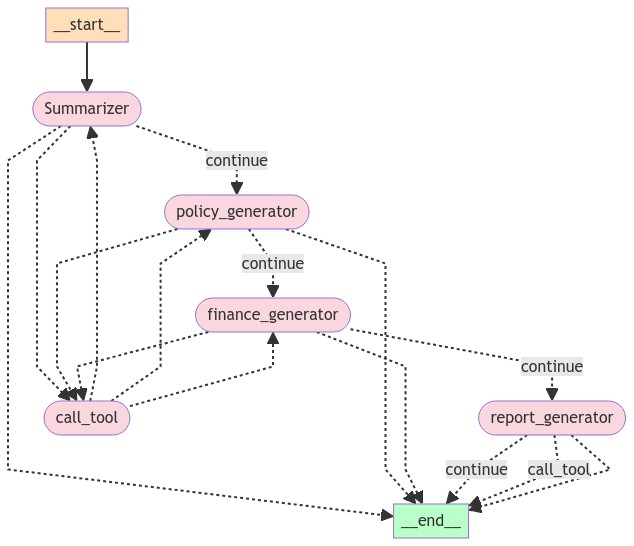

In [50]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass




In [51]:
# Invoke the graph and get the final state
final_state = graph.invoke(
    {
        "messages": [
            HumanMessage(
                content="""Project Overview:

The owner of Marbury Plaza wants to finance a comprehensive, deep energy retrofit of the property, including a 500kW solar project on the roof. The retrofit measures include:

Envelope Improvements: Insulation, windows, air tightness, etc.

Electric Lighting: Fixture upgrades, etc.

Efficient Equipment

Heating, Cooling & Ventilation

Total Cost:

Retrofit Measures: $50,000,000

Rooftop Solar Project: $1,500,000

Total: $51,500,000

Project Timeline:

Start: January 2025

Completion: July 2026

Compliance Standards:

Domestic sourcing of materials

Prevailing wage requirements

Davis-Bacon requirements

Assumptions:

The project will meet compliance standards related to workforce and materials.

All necessary permits and approvals will be obtained in a timely manner.

The owner is willing to explore and apply for various financing options."""
            )
        ]
    },
    {"recursion_limit": 150}
)

# Extract the final response from the final state
final_response = final_state["messages"][-1]

# Print the final response
print(final_response["content"])


Agent 'Summarizer' is processing the state.
Result from agent 'Summarizer': content='["Owner of Marbury Plaza wants to finance a comprehensive, deep energy retrofit including a 500kW solar project on the roof.", "Retrofit Measures: Insulation, windows, air tightness, lighting fixture upgrades, efficient equipment, heating, cooling, and ventilation.", "Total Cost: Retrofit Measures: $50,000,000, Rooftop Solar Project: $1,500,000, Total: $51,500,000.", "Project Timeline: Start: January 2025, Completion: July 2026.", "Compliance Standards: Domestic sourcing of materials, prevailing wage requirements, Davis-Bacon requirements.", "Assumptions: Project will meet compliance standards, all necessary permits and approvals will be obtained timely, owner will explore and apply for various financing options."]' response_metadata={'token_usage': {'completion_tokens': 159, 'prompt_tokens': 323, 'total_tokens': 482}, 'model_name': 'gpt-4o-2024-05-13', 'system_fingerprint': 'fp_4008e3b719', 'finish_re

In [56]:
from google.colab import userdata
import os
from qdrant_client import QdrantClient
from langchain.document_loaders import PDFPlumberLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.embeddings.openai import OpenAIEmbeddings
from langchain.vectorstores.qdrant import Qdrant
from langchain_openai import ChatOpenAI
from langchain.prompts import PromptTemplate
from langchain_core.runnables import RunnablePassthrough
from langchain_core.output_parsers import StrOutputParser
from typing import List, Optional, Type
from langchain import hub
from langchain_core.messages import (
    BaseMessage,
    HumanMessage,
    ToolMessage,
)
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langgraph.graph import END, StateGraph
from langchain.pydantic_v1 import BaseModel, Field
from langchain_core.tools import BaseTool
from langchain_openai import ChatOpenAI
import functools
from langchain_core.messages import AIMessage

import operator
from typing import Annotated, Sequence, TypedDict, Literal

class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]
    sender: str

class WorkflowManager:
    def __init__(self, openai_api_key: str):
        self.openai_api_key = openai_api_key
        self.llm = ChatOpenAI(model="gpt-4o", api_key=openai_api_key)
        self.report_tool_instance = self._create_report_tool()
        self.workflow = StateGraph(AgentState)
        self._setup_workflow()
        self.graph = self.workflow.compile()

    def _create_report_tool(self):
        class ReportToolInput(BaseModel):
            query: List[str] = Field(description="A list of inputs for the RAG pipeline")

        class ReportTool(BaseTool):
            name: str = "report_tool"
            description: str = "Tool to retrieve relevant documents from the vector database using a list of user queries and return a response."
            args_schema: Optional[Type[BaseModel]] = ReportToolInput
            return_direct: bool = True

            def _run(self, query: List[str]) -> str:
                try:
                    qdrant_end = userdata.get('qdrant_end')
                    qdrant_api_key = userdata.get('qdrant')
                    openai_api_key = userdata.get('openai_api_key')

                    embeddings_model = OpenAIEmbeddings(model='text-embedding-ada-002', openai_api_key=openai_api_key)
                    qdrant_client = QdrantClient(url=qdrant_end, api_key=qdrant_api_key)
                    qdrant = Qdrant(client=qdrant_client, collection_name="policy-agent", embeddings=embeddings_model)
                    retriever = qdrant.as_retriever(search_kwargs={"k": 3})
                    responses = []
                    for q in query:
                        response = retriever.invoke(q)
                        responses.append((response))

                    return responses

                except Exception as e:
                    return f"Error processing the query: {e}"

        return ReportTool()

    def create_agent(self, system_message: str, tools=None):
        tool_names = ", ".join([tool.name for tool in tools]) if tools else "None"
        prompt = ChatPromptTemplate.from_messages(
            [
                (
                    "system",
                    "You are a helpful AI assistant, collaborating with other assistants."
                    " Use the provided tools to progress towards answering the question."
                    " If you are unable to fully answer, that's OK, another assistant with different tools "
                    " will help where you left off. Execute what you can to make progress."
                    " If you or any of the other assistants have the final answer or deliverable,"
                    " prefix your response with FINAL ANSWER so the team knows to stop."
                    " You have access to the following tools: {tool_names}.\n{system_message}",
                ),
                MessagesPlaceholder(variable_name="messages"),
            ]
        )
        prompt = prompt.partial(system_message=system_message, tool_names=tool_names)
        if tools:
            return prompt | self.llm.bind_tools(tools)
        else:
            return prompt | self.llm

    def agent_node(self, state, agent, name):
        print(f"Agent '{name}' is processing the state.")
        result = agent.invoke(state)
        print(f"Result from agent '{name}': {result}")

        if isinstance(result, ToolMessage):
            print(f"ToolMessage from agent '{name}': {result}")
        else:
            result = AIMessage(**result.dict(exclude={"type", "name"}), name=name)
            print(f"AIMessage from agent '{name}': {result}")

        return {
            "messages": [result],
            "sender": name,
        }

    def _setup_workflow(self):
        summary_agent = self.create_agent(
            system_message="Summarize the user query. You should include all important data like financial figures, dates, etc. Output format should be a python list of strings.",
        )
        summary_node = functools.partial(self.agent_node, agent=summary_agent, name="Summarizer")

        policy_agent = self.create_agent(
            system_message=(
                "You have the following tasks"
                "1.Create a single comprehensive question from the summary provided by summary agent which includes all financial, date, and project-related data"
                "2.Prepend 'What are the compliance criteria, eligibility criteria, fees' at the beginning of the question."
                "3.Use the question to call_tool."
                "4.Your input to the tool has to be a list of python string."
                "5.After receiving the docs from the tool, extract the information related to the input question into a single document having headers and sub-heading"
                "Keep in view the following points:"
                "1.Remember you have to craft the question from the text not related to the text."
                "2.While drafting the document, keep in mind the input question."
                "3.Do not finalize the answer or add 'FINAL ANSWER' in your response."
                "4.Return 'continue' after creating the document to call the next agent properly"
            ),
            tools=[self.report_tool_instance]
        )
        policy_node = functools.partial(self.agent_node, agent=policy_agent, name="policy_generator")

        financial_agent = self.create_agent(
            system_message=(
                "You have the following tasks"
                "1.Create a single comprehensive question from the summary provided by summary agent which includes all financial, date, and project-related data"
                "2.Prepend ' What are the financing options, subsidies, grants, and incentives available' at the beginning of the question."
                "3.Use the question to call_tool."
                "4.Your input to the tool has to be a list of python string."
                "5.After receiving the docs from the tool, extract the information related to the input question into a single document having headers and sub-heading"
                "Keep in view the following points:"
                "1.Remember you have to craft the question from the text not related to the text."
                "2.Do not finalize the answer or add 'FINAL ANSWER' in your response."
                "3.While drafting the document, keep in mind the input question."
            ),
            tools=[self.report_tool_instance]
        )
        finance_node = functools.partial(self.agent_node, agent=financial_agent, name="finance_generator")

        report_agent = self.create_agent(
            system_message=(
                "You have the following tasks"
                "1.Collect the answers generated by policy_agenst and financial agent"
                "2.Read the answers by both agensts"
                "3.Create a commulative report from these two agents responses"
                "4.Be detail oriented, Genuine and Act as an expert report generator"
                "5.prefix your response with FINAL ANSWER so the team knows to stop."
            ),
        )
        report_node = functools.partial(self.agent_node, agent=report_agent, name="report_generator")

        tools = [self.report_tool_instance]
        tool_node = ToolNode(tools)

        def router(state) -> Literal["call_tool", "__end__", "continue"]:
            messages = state["messages"]
            last_message = messages[-1]
            print(f"Router checking the last message from sender '{state['sender']}': {last_message}")

            if last_message.tool_calls:
                print("Router directing to call_tool.")
                return "call_tool"
            if "FINAL ANSWER" in last_message.content:
                print("Router directing to __end__.")
                return "__end__"
            print("Router directing to continue.")
            return "continue"

        self.workflow.add_node("Summarizer", summary_node)
        self.workflow.add_node("policy_generator", policy_node)
        self.workflow.add_node("finance_generator", finance_node)
        self.workflow.add_node("report_generator", report_node)
        self.workflow.add_node("call_tool", tool_node)

        self.workflow.add_conditional_edges(
            "Summarizer",
            router,
            {"continue": "policy_generator", "call_tool": "call_tool", "__end__": END},
        )
        self.workflow.add_conditional_edges(
            "policy_generator",
            router,
            {"continue": "finance_generator", "call_tool": "call_tool", "__end__": END},
        )
        self.workflow.add_conditional_edges(
            "finance_generator",
            router,
            {"continue": "report_generator", "call_tool": "call_tool", "__end__": END},
        )
        self.workflow.add_conditional_edges(
            "report_generator",
            router,
            {"continue": "__end__", "call_tool": "__end__", "__end__": END},
        )
        self.workflow.add_conditional_edges(
            "call_tool",
            lambda x: x["sender"],
            {
                "Summarizer": "Summarizer",
                "policy_generator": "policy_generator",
                "finance_generator": "finance_generator"
            },
        )
        self.workflow.set_entry_point("Summarizer")

    def run(self, initial_message: str):
        final_state = self.graph.invoke(
            {
                "messages": [
                    HumanMessage(
                        content=initial_message
                    )
                ]
            },
            {"recursion_limit": 150}
        )
        final_response = final_state["messages"][-1]
        print(final_response.content)

In [57]:
# Example usage
openai_api_key = userdata.get('openai_api_key')
workflow_manager = WorkflowManager(openai_api_key)

initial_message = """Project Overview:

The owner of Marbury Plaza wants to finance a comprehensive, deep energy retrofit of the property, including a 500kW solar project on the roof. The retrofit measures include:

Envelope Improvements: Insulation, windows, air tightness, etc.

Electric Lighting: Fixture upgrades, etc.

Efficient Equipment

Heating, Cooling & Ventilation

Total Cost:

Retrofit Measures: $50,000,000

Rooftop Solar Project: $1,500,000

Total: $51,500,000

Project Timeline:

Start: January 2025

Completion: July 2026

Compliance Standards:

Domestic sourcing of materials

Prevailing wage requirements

Davis-Bacon requirements

Assumptions:

The project will meet compliance standards related to workforce and materials.

All necessary permits and approvals will be obtained in a timely manner.

The owner is willing to explore and apply for various financing options."""

workflow_manager.run(initial_message)


Agent 'Summarizer' is processing the state.
Result from agent 'Summarizer': content='[\n    "Owner of Marbury Plaza wants to finance a comprehensive deep energy retrofit and a 500kW solar project on the roof.",\n    "Retrofit measures include: Envelope Improvements, Electric Lighting, Efficient Equipment, Heating, Cooling & Ventilation.",\n    "Total cost for Retrofit Measures: $50,000,000",\n    "Total cost for Rooftop Solar Project: $1,500,000",\n    "Total project cost: $51,500,000",\n    "Project timeline: Start - January 2025, Completion - July 2026",\n    "Compliance standards: Domestic sourcing of materials, Prevailing wage requirements, Davis-Bacon requirements",\n    "Assumptions: Project will meet compliance standards, permits and approvals will be obtained timely, owner will explore financing options"\n]' response_metadata={'token_usage': {'completion_tokens': 163, 'prompt_tokens': 323, 'total_tokens': 486}, 'model_name': 'gpt-4o-2024-05-13', 'system_fingerprint': 'fp_d57630